# Cargo: Finding the Best Distribution with AIS Dataset

In [1]:
# Loading libraries
import scipy.stats as stats
from scipy.stats import chi2

import matplotlib.pyplot as plt
from six.moves import urllib
import zipfile
from scipy import stats

import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Loading dataset
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '624bc4e1-3ea7-4a94-93f3-4f3f3e4c45fa'
resource_group = 'erspc-test-resource-group'
workspace_name = 'DryRunMLWorkspace'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='ais-with-larger-geospatial-limit')
ais_reporting_rates = dataset.to_pandas_dataframe()


In [3]:
# check the number of observations and data types
ais_reporting_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368949 entries, 0 to 368948
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   message_id          368949 non-null  int64         
 1   mmsi                368949 non-null  int64         
 2   message_time_stamp  368949 non-null  datetime64[ns]
 3   lat                 368949 non-null  float64       
 4   lon                 368949 non-null  float64       
 5   heading             368949 non-null  float64       
 6   sog                 368949 non-null  float64       
 7   status              368949 non-null  object        
 8   destination         361968 non-null  object        
 9   vessel_type         368949 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 28.1+ MB


In [4]:
#checking the first 5 records in the data
ais_reporting_rates.head()

,message_id,mmsi,message_time_stamp,lat,lon,heading,sog,status,destination,vessel_type
0,9428086,11223344,2020-03-12 17:21:26,50.423552,-0.580688,254.0,12.7,Under way using engine,None,N/A
1,9429453,11223344,2020-03-12 17:26:44,50.419567,-0.609708,260.0,12.6,Under way using engine,None,N/A
2,9430776,11223344,2020-03-12 17:31:22,50.416072,-0.635027,260.0,13.1,Under way using engine,None,N/A
3,9432046,11223344,2020-03-12 17:36:45,50.411950,-0.664525,260.0,13.0,Under way using engine,None,N/A
4,9433162,11223344,2020-03-12 17:42:02,50.407778,-0.693447,260.0,13.0,Under way using engine,None,N/A


In [5]:
#checking the last 5 records in the data
ais_reporting_rates.tail()

,message_id,mmsi,message_time_stamp,lat,lon,heading,sog,status,destination,vessel_type
368944,11479752,710032130,2020-03-20 20:42:00,50.306265,-1.157915,257.0,13.0,Under way sailing,ANGRA DOS REIS_BRA,Tanker
368945,11480956,710032130,2020-03-20 20:56:41,50.294537,-1.239870,257.0,13.2,Under way sailing,ANGRA DOS REIS_BRA,Tanker
368946,11481903,710032130,2020-03-20 21:00:41,50.291395,-1.262475,257.0,13.5,Under way sailing,ANGRA DOS REIS_BRA,Tanker
368947,11482991,710032130,2020-03-20 21:06:40,50.286498,-1.296945,257.0,13.7,Under way sailing,ANGRA DOS REIS_BRA,Tanker
368948,11484116,710032130,2020-03-20 21:12:03,50.282047,-1.328098,257.0,13.8,Under way sailing,ANGRA DOS REIS_BRA,Tanker


In [6]:
ais_reporting_rates.shape

(368949, 10)

In [7]:
# #checking the columns
ais_reporting_rates.columns

Index(['message_id', 'mmsi', 'message_time_stamp', 'lat', 'lon', 'heading',
       'sog', 'status', 'destination', 'vessel_type'],
      dtype='object')

In [8]:
# check unique vessel_type
ais_reporting_rates["vessel_type"].unique()

array(['N/A', 'Search And Rescue', 'Vessel', 'Tanker', 'Cargo',
       'Wing In Ground-effect', 'Passenger', 'Tug', 'Law Enforcement',
       'High Speed Craft'], dtype=object)

In [9]:
# select tug from ais_reporting_rates
select_cargo = ais_reporting_rates.loc[ais_reporting_rates["vessel_type"] == 'Cargo']
select_cargo.head()

,message_id,mmsi,message_time_stamp,lat,lon,heading,sog,status,destination,vessel_type
9912,1130109,205439000,2020-02-14 04:53:27,49.731933,-0.435420,143.0,8.6,Under way using engine,BE ANR_FR URO,Cargo
9913,1131338,205439000,2020-02-14 04:58:48,49.720943,-0.425573,140.0,8.7,Under way using engine,BE ANR_FR URO,Cargo
9914,1132600,205439000,2020-02-14 05:03:27,49.711340,-0.416870,140.0,8.6,Under way using engine,BE ANR_FR URO,Cargo
9915,1133840,205439000,2020-02-14 05:07:57,49.701975,-0.408578,139.0,8.6,Under way using engine,BE ANR_FR URO,Cargo
9916,1135058,205439000,2020-02-14 05:13:27,49.690483,-0.398583,139.0,8.6,Under way using engine,BE ANR_FR URO,Cargo


In [10]:
select_cargo.shape

(197475, 10)

In [11]:
to_drop = ['message_id', 'mmsi','message_time_stamp','lat','lon','heading','status','destination','vessel_type']

select_cargo.drop(to_drop, inplace=True, axis=1)


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
select_cargo

,sog
9912,8.6
9913,8.7
9914,8.6
9915,8.6
9916,8.6
...,...
368603,18.6
368604,18.6
368605,18.7
368606,18.7


In [13]:
select_cargo.values

array([[ 8.6],
       [ 8.7],
       [ 8.6],
       ...,
       [18.7],
       [18.7],
       [18.7]])

,sumsquare_error,aic,bic,kl_div
genlogistic,0.005878,1048.725316,-3.422171e+06,inf
powernorm,0.006401,1296.360186,-3.405346e+06,inf
pearson3,0.006494,1347.257116,-3.402498e+06,inf
loggamma,0.006511,1328.668346,-3.401980e+06,inf
logistic,0.006684,1016.553496,-3.396812e+06,inf


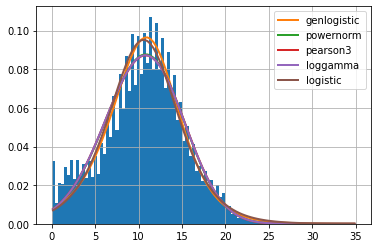

In [14]:
f = Fitter(select_cargo,
           distributions = get_distributions())
f.fit()
f.summary()